# Sentiment Analysis of IMDB Reviews using LSTM

# Table of Contents

1. [Introduction](#Introduction)
2. [Data Preparation and Visualization](#Data-Preparation-and-Visualization)
    - [Loading the Dataset]
    - [Word Frequency Analysis]
    - [Review Length Analysis]
3. [Building and Training the LSTM Model](#Building-and-Training-the-LSTM-Model)
    - [Model Architecture]
    - [Model Training]
4. [Evaluating Model Performance](#Evaluating-Model-Performance)
    - [Loss and Accuracy Plots]
    - [Confusion Matrix]
5. [Visualization of Results](#Visualization-of-Results)
    - [Word Clouds for Reviews]
    - [Sample Predictions]
6. [Saving and Loading the Model](#Saving-and-Loading-the-Model)
7. [Conclusion](#Conclusion)


<!-- <a id="Introduction"></a> -->
# Introduction


#### The goal of this notebook is to provide a clear and detailed workflow for sentiment analysis, from data processing to model evaluation, with a focus on utilizing LSTM networks, a type of recurrent neural network particularly well-suited for sequence data like text.
---

# Importing Libraries

In [100]:

# TensorFlow and Keras for building the neural network
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
# Matplotlib for plotting, Seaborn for advanced visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# WordCloud for text visualization
from wordcloud import WordCloud
# NumPy for numerical operations
import numpy as np
from collections import Counter
# Sklearn for model evaluation metrics,
from sklearn.metrics import confusion_matrix

<a id="Data-Preparation-and-Visualization"></a>
# Data Preparation and Visualization
#### The dataset is a set of movie reviews, labeled as positive (1) or negative (0). The reviews are preprocessed and each word is replaced by an integer index `num_words=10000` keeps only the top 10,000 most common words in the dataset
---

In [114]:
# Loading the IMDB dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# Print shapes of training and test data
print("Training data shape:", train_data.shape)
print("Training labels shape:", train_labels.shape)

# IMDB dataset's word index
# This maps words to integers, which is how the data is encoded
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Reverse Word Index
# This reverses the mapping of word_index to map integers back to words
# Useful for understanding and visualizing the dataset
decoded_reviews = [' '.join([reverse_word_index.get(i - 3, '?') for i in review]) for review in train_data]

Training data shape: (25000,)
Training labels shape: (25000,)


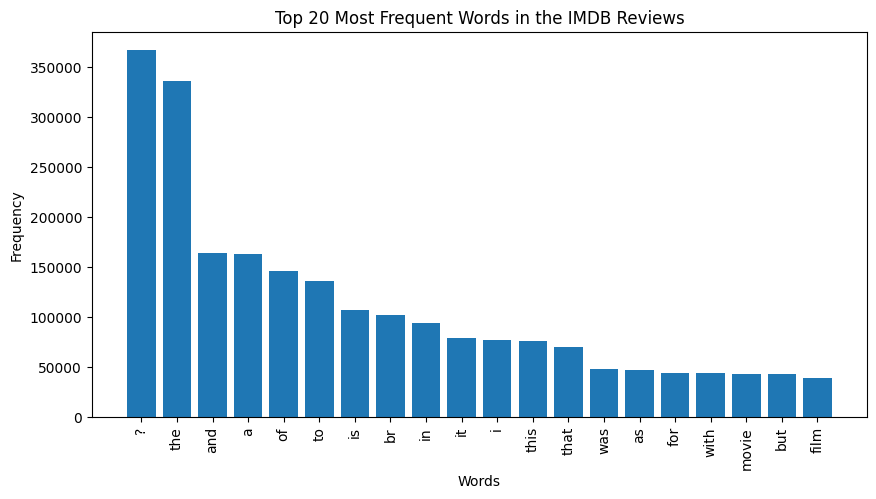

In [102]:
# Word Frequency Analysis
# Understanding the most common words in the reviews can give insights into the dataset
all_words = ' '.join(decoded_reviews).split()
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

# Plotting Word Frequencies
# This helps in visually analyzing the most frequent words in the dataset
plt.figure(figsize=(10, 5))
plt.bar(*zip(*most_common_words))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Words in the IMDB Reviews')
plt.show()

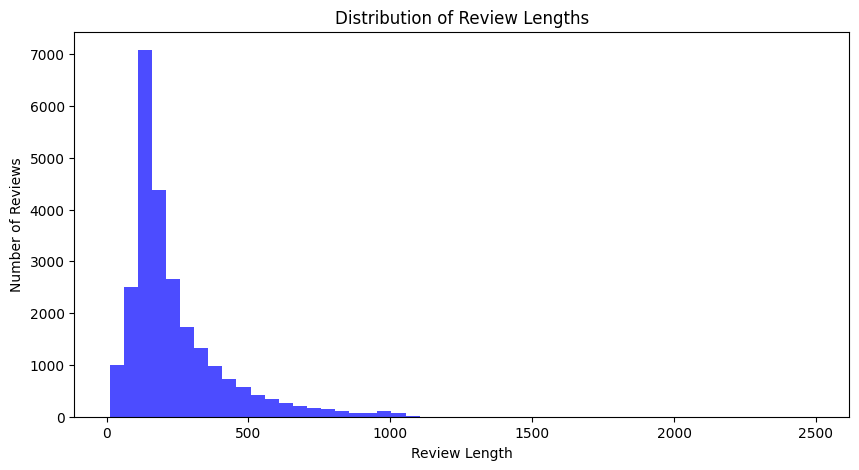

Mean review length: 238.71364
Median review length: 178.0


In [103]:
# Review Length Analysis
# Understanding the length of reviews can give insights into the dataset's complexity
review_lengths = [len(review) for review in train_data]
plt.figure(figsize=(10, 5))
plt.hist(review_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.show()

# Calculate mean and median of review lengths
mean_length = np.mean(review_lengths)
median_length = np.median(review_lengths)
print("Mean review length:", mean_length)
print("Median review length:", median_length)

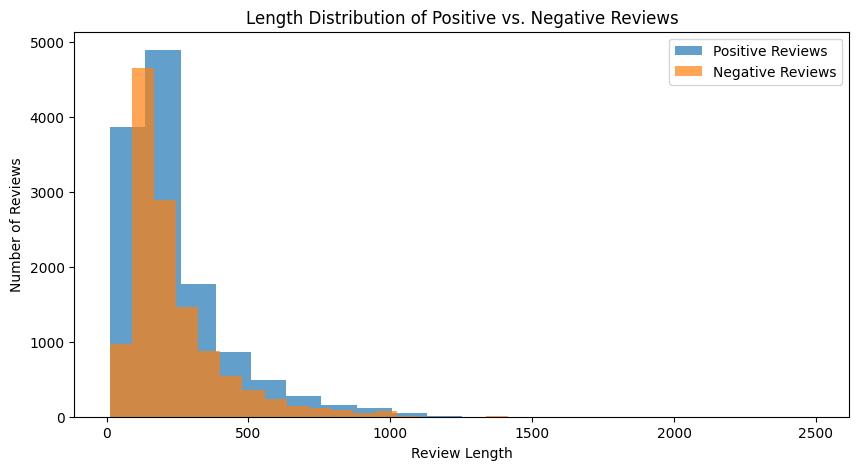

In [104]:
# Separate lengths for positive and negative reviews
positive_lengths = [review_lengths[i] for i in range(len(review_lengths)) if train_labels[i] == 1]
negative_lengths = [review_lengths[i] for i in range(len(review_lengths)) if train_labels[i] == 0]

# Plotting
plt.figure(figsize=(10, 5))
plt.hist(positive_lengths, bins=20, alpha=0.7, label='Positive Reviews')
plt.hist(negative_lengths, bins=20, alpha=0.7, label='Negative Reviews')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.title('Length Distribution of Positive vs. Negative Reviews')
plt.legend()
plt.show()

<a id="Building-and-Training-the-LSTM-Model"></a>
## Building and Training the LSTM Model
---



In [105]:
# Set maximum review length
# Padding the Sequences
# This makes all reviews a uniform length, which is necessary for input into a neural network
max_len = 350  # Length is chosen based on analysis of review lengths
train_data = pad_sequences(train_data, maxlen=max_len)
test_data = pad_sequences(test_data, maxlen=max_len)

# Defining the LSTM Model
# The model consists of an Embedding layer, an LSTM layer, and a Dense output layer
model = Sequential([
    Embedding(10000, 16, input_length=max_len),  # Turns positive integers (indexes) into dense vectors of fixed size
    LSTM(32, dropout=0.3),  # LSTM layer with 32 units and 30% dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the Model
# RMSprop optimizer is used with binary crossentropy loss, as it's a binary classification problem
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Training the Model
# The model is trained for 10 epochs with a batch size of 128
# 20% of the training data is used as a validation set to monitor the model's performance
model_checkpoint = ModelCheckpoint('trained_model.h5', save_best_only=True)
history = model.fit(train_data, train_labels, epochs=10, batch_size=128, validation_split=0.2, callbacks=[model_checkpoint])

Epoch 1/10
157/157 [==============================] - 25s 129ms/step - loss: 0.6303 - acc: 0.6324 - val_loss: 0.4789 - val_acc: 0.7850
Epoch 2/10
  2/157 [..............................] - ETA: 10s - loss: 0.4629 - acc: 0.8008

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 10s 63ms/step - loss: 0.3934 - acc: 0.8343 - val_loss: 0.6341 - val_acc: 0.7294
Epoch 3/10
157/157 [==============================] - 5s 34ms/step - loss: 0.2990 - acc: 0.8780 - val_loss: 0.3795 - val_acc: 0.8330
Epoch 4/10
157/157 [==============================] - 7s 44ms/step - loss: 0.2528 - acc: 0.9018 - val_loss: 0.2843 - val_acc: 0.8848
Epoch 5/10
157/157 [==============================] - 5s 29ms/step - loss: 0.2242 - acc: 0.9141 - val_loss: 0.3602 - val_acc: 0.8700
Epoch 6/10
157/157 [==============================] - 4s 26ms/step - loss: 0.2000 - acc: 0.9258 - val_loss: 0.3516 - val_acc: 0.8718
Epoch 7/10
157/157 [==============================] - 4s 29ms/step - loss: 0.1813 - acc: 0.9326 - val_loss: 0.3159 - val_acc: 0.8886
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - loss: 0.1689 - acc: 0.9386 - val_loss: 0.3653 - val_acc: 0.8540
Epoch 9/10
157/157 [==============================] - 3s 20ms/step - loss: 0.15

<a id="Evaluating-Model-Performance"></a>
# Evaluating Model Performance

#### Plotting Training and Validation Loss and Accuracy. These plots help us to understand how well the model is learning over time. Loss plot helps in identifying underfitting or overfitting trends. Accuracy plot provides a clear picture of the model's performance improvements per epoch
---

In [106]:
# Evaluate model on test data
loss, accuracy = model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")

782/782 [==============================] - 5s 6ms/step - loss: 0.3268 - acc: 0.8696
Test Accuracy: 86.96%


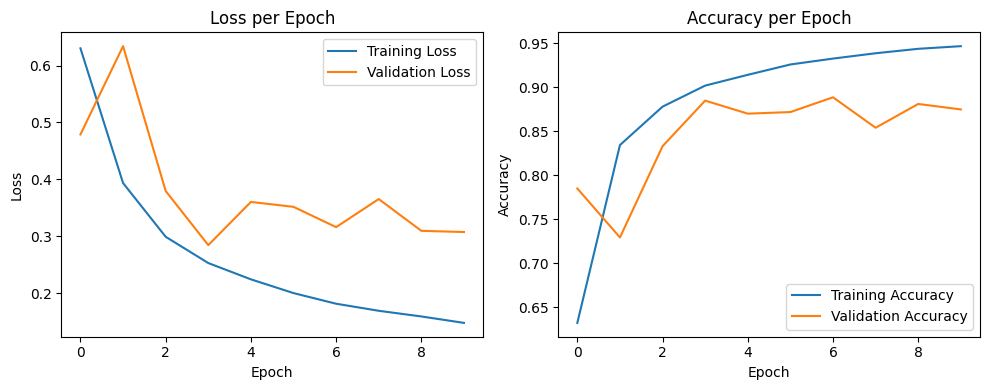

In [107]:
# Plotting Loss per Epoch
# Training Loss and Validation Loss are plotted to understand the learning trends
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy per Epoch
# Training Accuracy and Validation Accuracy are plotted for performance insights
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

782/782 [==============================] - 5s 5ms/step


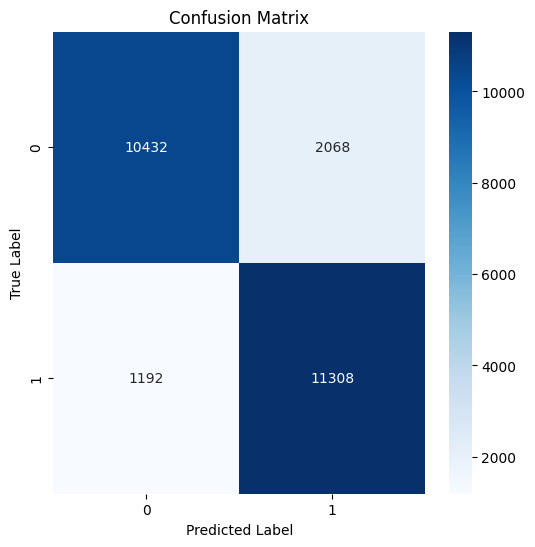

In [108]:
# Confusion Matrix
# Provides a summary of prediction results on a classification problem
# Helpful to see the model's performance in terms of false positives, false negatives, etc.

# Predicting Test Data
y_pred_classes = (model.predict(test_data) > 0.5).astype("int32")

# Creating the Confusion Matrix
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

<a id="Visualization-of-Results"></a>
# Visualization of Results
#### Word Clouds for Positive and Negative Reviews. This visualization helps in understanding the most common words in each category of reviews

In [109]:


# Function to Generate Word Cloud
def generate_word_cloud(text_data):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(text_data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Word Cloud for Positive Reviews


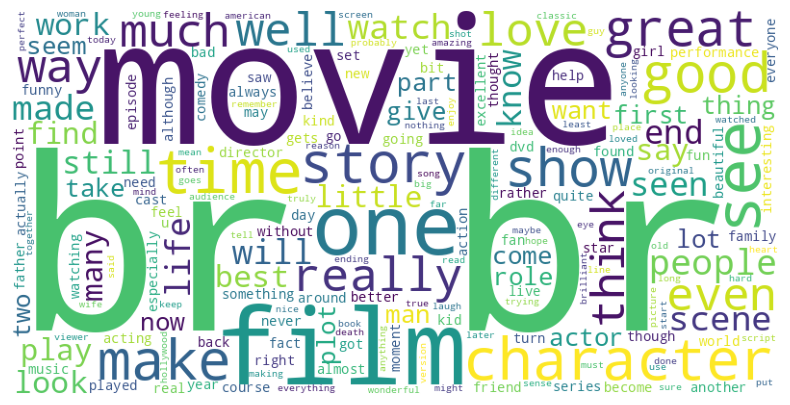

In [110]:
# Generating Word Clouds for Positive Reviews
positive_reviews = [" ".join([reverse_word_index.get(i - 3, '?') for i in review]) for review, label in zip(train_data, train_labels) if label == 1]
print("Word Cloud for Positive Reviews")
generate_word_cloud(positive_reviews)

Word Cloud for Negative Reviews


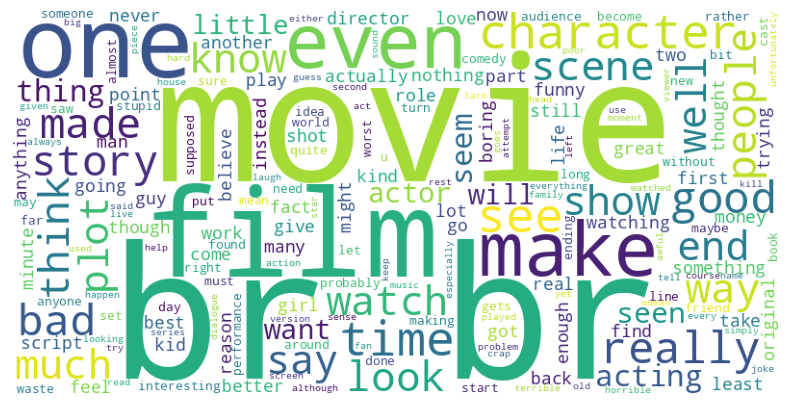

In [111]:
# Generating Word Clouds for Negative Reviews
negative_reviews = [" ".join([reverse_word_index.get(i - 3, '?') for i in review]) for review, label in zip(train_data, train_labels) if label == 0]
print("Word Cloud for Negative Reviews")
generate_word_cloud(negative_reviews)

<a id="Sample-Predictions"></a>
# Sample Predictions

#### Making Predictions on Sample Test Data. This section showcases how the model performs on unseen data. It compares the predicted sentiment against the actual sentiment

In [112]:
# Sample some test data for predictions
sample_data = test_data[:10]
sample_labels = test_labels[:10]  # Corresponding true labels

# Model Predictions
predictions = model.predict(sample_data)

# For each prediction, determine the predicted and actual sentiment
for i, pred in enumerate(predictions):
    predicted_sentiment = "Positive" if pred > 0.5 else "Negative"
    actual_sentiment = "Positive" if sample_labels[i] == 1 else "Negative"
    print(f"Review {i}: Predicted Sentiment - {predicted_sentiment}, Actual Sentiment - {actual_sentiment}")


1/1 [==============================] - 0s 37ms/step
Review 0: Predicted Sentiment - Negative, Actual Sentiment - Negative
Review 1: Predicted Sentiment - Positive, Actual Sentiment - Positive
Review 2: Predicted Sentiment - Positive, Actual Sentiment - Positive
Review 3: Predicted Sentiment - Negative, Actual Sentiment - Negative
Review 4: Predicted Sentiment - Positive, Actual Sentiment - Positive
Review 5: Predicted Sentiment - Positive, Actual Sentiment - Positive
Review 6: Predicted Sentiment - Positive, Actual Sentiment - Positive
Review 7: Predicted Sentiment - Negative, Actual Sentiment - Negative
Review 8: Predicted Sentiment - Positive, Actual Sentiment - Negative
Review 9: Predicted Sentiment - Positive, Actual Sentiment - Positive



<a id="Saving-and-Loading-the-Model"></a>
# Saving and Loading the Model

In [116]:
# Load the previously trained and saved model
model = load_model('trained_model.h5')

# Loading the IMDB dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

max_len = 350  # Following the training configuration
test_data = pad_sequences(test_data, maxlen=max_len)

# Evaluate the loaded model on the test dataset
# This is to ensure that the saved model performs as expected
loss, accuracy = model.evaluate(test_data, test_labels)

# Print the test accuracy of the loaded model
print(f"Test Accuracy of the loaded model: {accuracy * 100:.2f}%")

782/782 [==============================] - 6s 7ms/step - loss: 0.2890 - acc: 0.8789
Test Accuracy of the loaded model: 87.89%


<a id="Conclusion"></a>
# Conclusion
#### This notebook demonstrated sentiment analysis on IMDB reviews using an LSTM model. We covered data preparation, visualization, model building, and evaluation. The insights and techniques showcased are intended to be a valuable resource for similar projects in natural language processing. I hope you find it useful in your journey through deep learning and data analysis.

#### Happy exploring!